# 1. Import of libraries and load of datasets

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump

from imblearn.over_sampling import RandomOverSampler

import re
import spacy

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# import spacy.cli 
# spacy.cli.download("de_core_news_sm")

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
X_train = train.Review
y_train = train.Rate

X_test = test.Review
y_test = test.Rate

# 2. Handling Imbalance

In [4]:
np.sum(train.Rate == 1), np.sum(train.Rate == 0)

(3758, 2400)

Let's deal with this problem, using oversampling method.

In [5]:
X_over, y_over = RandomOverSampler(random_state=108).fit_resample(X_train.values.reshape(-1, 1), y_train)

In [6]:
sum(y_over) / len(y_over)

0.5

Now, the data is balanced

In [7]:
X_over = pd.Series(X_over.reshape(-1,))

# 3. Text preprocessing

## 3.1 Lowerization

In [8]:
X_over.head(5)

0     Das Gerät kam schnell und einwandfrei an!
1           So wie ich es mir vorgestellt habe.
2    Missing head phones please bring it thanks
3                   Sehr gutes Handy top Kamera
4       Gutes Produkt. Sehr Weiter zu empfehlen
dtype: object

In [9]:
X_over = X_over.apply(lambda x: x.lower())
X_test = X_test.apply(lambda x: x.lower())

In [10]:
X_over.head(5)

0     das gerät kam schnell und einwandfrei an!
1           so wie ich es mir vorgestellt habe.
2    missing head phones please bring it thanks
3                   sehr gutes handy top kamera
4       gutes produkt. sehr weiter zu empfehlen
dtype: object

## 3.2 Punctuation

In [11]:
punct_list = '["#$%&\'()*+,-./:;<=>@[\]^_`{|}~’‘´`\']'

In [12]:
X_over = X_over.apply(lambda x: re.sub(punct_list, "", x))
X_test = X_test.apply(lambda x: re.sub(punct_list, "", x))

## 3.3 Numbers removing

In [13]:
X_over = X_over.apply(lambda x: re.sub("\d+", "", x))
X_test = X_test.apply(lambda x: re.sub("\d+", "", x))

## 3.4 Lemmatization

In [14]:
nlp = spacy.load('de_core_news_sm')

In [15]:
X_over = X_over.apply(lambda sentence: " ".join([token.lemma_ for token in nlp(sentence)]))
X_test = X_test.apply(lambda sentence: " ".join([token.lemma_ for token in nlp(sentence)]))

# 4. Modeling

## 4.1 Search of optimal coefficient C

In [16]:
C_list = np.linspace(0.1, 20, 30)
acc_list = []

for C in tqdm(C_list):
    pi = Pipeline([('counter', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('lr', LogisticRegression(C=C))])
    res = cross_val_score(estimator=pi, X=X_over, y=y_over, cv=5, scoring='accuracy')
    acc_list.append(res.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:39<00:00,  7.32s/it]


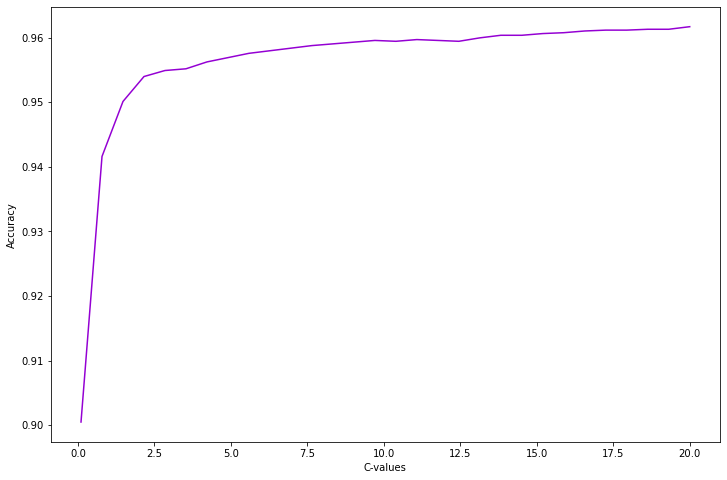

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(C_list, acc_list, color='darkviolet')
plt.xlabel('C-values')
plt.ylabel('Accuracy');

## 4.2 Search of optimal coefficient C and n-grams

In [18]:
%%time
C_list = [20 + (i-3) for i in range(10)]
n_list = [1 + i for i in range(10)]
acc_list = [[0] * 10 for i in range(10)]

for i in tqdm(range(10)):
    for j in range(10):
        pi = Pipeline([('counter', CountVectorizer(ngram_range=(1, n_list[i]))),
                       ('tfidf', TfidfTransformer()),
                       ('lr', LogisticRegression(C=C_list[j]))])
        res = cross_val_score(estimator=pi, X=X_over, y=y_over, cv=5, scoring='accuracy')
        acc_list[i][j] = res.mean()

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:18:01<00:00, 468.12s/it]

Wall time: 1h 18min 1s


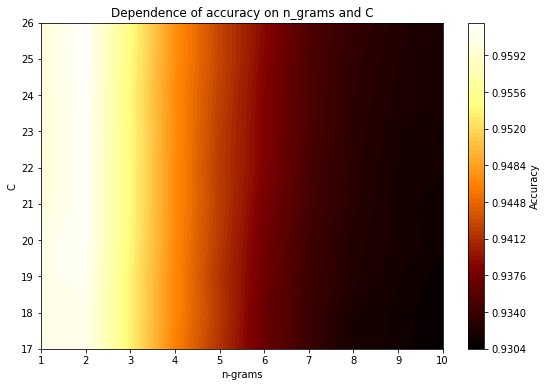

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
cs = ax.contourf(n_list, C_list, np.array(acc_list).T, cmap=cm.afmhot, levels=100)
cbar = fig.colorbar(cs)
cbar.set_label('Accuracy')
plt.title('Dependence of accuracy on n_grams and C')
plt.xlabel('n-grams')
plt.ylabel('C')
plt.savefig('imgs/grid.png');

In [20]:
C_win = 20
n_win = 2

## 4.3 Test

In [21]:
pi = Pipeline([('counter', CountVectorizer(ngram_range=(1, n_win))),
               ('tfidf', TfidfTransformer()),
               ('lr', LogisticRegression(C=C_win))])
pi.fit(X_over, y_over)

Pipeline(steps=[('counter', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('lr', LogisticRegression(C=20))])

In [22]:
pred = pi.predict(X_test)

In [23]:
print('Accuracy is equal', sum(pred == y_test) / y_test.shape[0])

Accuracy is equal 0.945985401459854


Such result is definetely acceptable.

# 5. Save of model

In [24]:
dump(pi, 'model.joblib')

['model.joblib']

In [25]:
features = pi['counter'].get_feature_names()

In [26]:
len(features)

89484

In [27]:
feats = list(zip(features, list(pi['lr'].coef_[0])))

In [28]:
feats.sort(key=lambda x: x[1], reverse=True)

In [29]:
top20 = [i[0] for i in feats[:20]]

In [30]:
feats.sort(key=lambda x: x[1])

In [31]:
neg20 = [i[0] for i in feats[:20]]

In [32]:
pd.DataFrame(neg20, columns=['Top negative phrases']).join(pd.DataFrame(top20, columns=['Top positive phrases'])).to_csv('top.csv', index=False)

In [33]:
pd.DataFrame(neg20, columns=['Top negative phrases']).join(pd.DataFrame(top20, columns=['Top positive phrases']))

,Top negative phrases,Top positive phrases
0,nicht,super
1,schlecht,top
2,zurück,toll
3,der,iphone
4,defekt,alle
5,kein,der gut
6,nach,schön
7,akku,zufrieden
8,langsam,apple
9,leider,gut gehen
